In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import skimage
from skimage.transform import resize
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import model_from_json


In [2]:
train_folder = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
1,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
2,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
3,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
4,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
...,...,...
86995,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86996,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86997,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86998,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...


In [3]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [4]:
img_width, img_height = 75, 75
batch_size = 16
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
    )

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 62640 validated image filenames belonging to 29 classes.
Found 15660 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [5]:
base_model = InceptionV3(input_shape=(75,75,3), weights='imagenet', include_top=False)
base_model.trainable = False

2022-04-29 14:30:05.479365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 14:30:05.571661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 14:30:05.572413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 14:30:05.574128: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 1s 0us/step


In [6]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
#dense_layer_2 = layers.Dense(512, activation='relu')
#dropout_layer_2 = layers.Dropout(0.5)
prediction_layer = layers.Dense(29, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    #dense_layer_2,
    #dropout_layer_2,
    prediction_layer
])

In [8]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                14877     
Total params: 22,866,749
Trainable params: 1,063,965
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
classes = 29
epochs = 10
learning_rate = 0.0001

adam = Adam(lr=learning_rate)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10


2022-04-29 14:30:11.686730: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-29 14:30:15.911678: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3915/3915 [==============================] - 437s 109ms/step - loss: 1.3719 - accuracy: 0.6183 - val_loss: 0.5417 - val_accuracy: 0.8717
Epoch 2/10
3915/3915 [==============================] - 150s 38ms/step - loss: 0.5349 - accuracy: 0.8477 - val_loss: 0.3016 - val_accuracy: 0.9300
Epoch 3/10
3915/3915 [==============================] - 150s 38ms/step - loss: 0.3361 - accuracy: 0.9042 - val_loss: 0.2015 - val_accuracy: 0.9535
Epoch 4/10
3915/3915 [==============================] - 149s 38ms/step - loss: 0.2345 - accuracy: 0.9345 - val_loss: 0.1538 - val_accuracy: 0.9624
Epoch 5/10
3915/3915 [==============================] - 150s 38ms/step - loss: 0.1791 - accuracy: 0.9504 - val_loss: 0.1192 - val_accuracy: 0.9709
Epoch 6/10
3915/3915 [==============================] - 150s 38ms/step - loss: 0.1389 - accuracy: 0.9618 - val_loss: 0.0956 - val_accuracy: 0.9765
Epoch 7/10
3915/3915 [==============================] - 150s 38ms/step - loss: 0.1132 - accuracy: 0.9689 - val_loss: 0.0828 - va

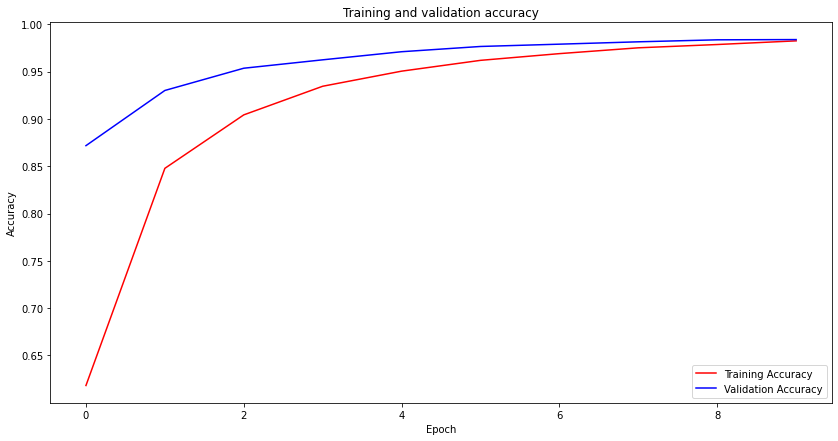

In [10]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

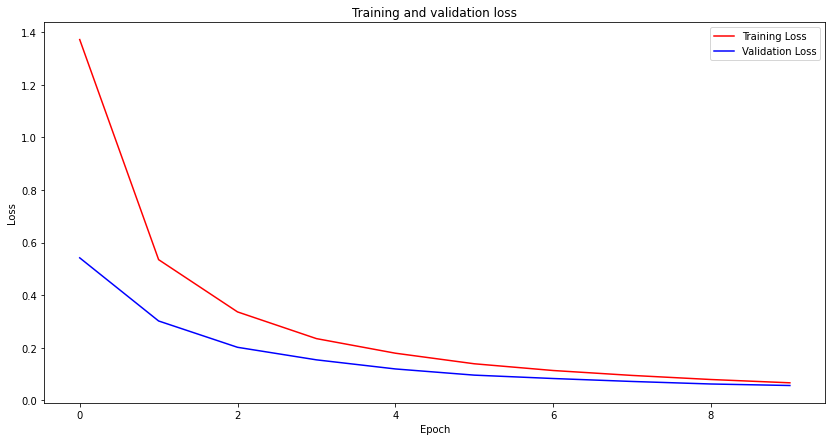

In [11]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [12]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

544/544 [==============================] - 57s 102ms/step
              precision    recall  f1-score   support

           A       0.99      0.98      0.99       300
           B       0.98      0.99      0.99       300
           C       1.00      0.99      0.99       300
           D       1.00      0.98      0.99       300
           E       0.99      0.99      0.99       300
           F       0.99      0.99      0.99       300
           G       1.00      0.97      0.99       300
           H       0.98      0.99      0.99       300
           I       1.00      0.98      0.99       300
           J       1.00      1.00      1.00       300
           K       0.97      0.99      0.98       300
           L       0.99      1.00      0.99       300
           M       0.97      0.99      0.98       300
           N       0.98      0.99      0.99       300
           O       0.99      0.98      0.99       300
           P       0.99      0.99      0.99       300
           Q       0.99

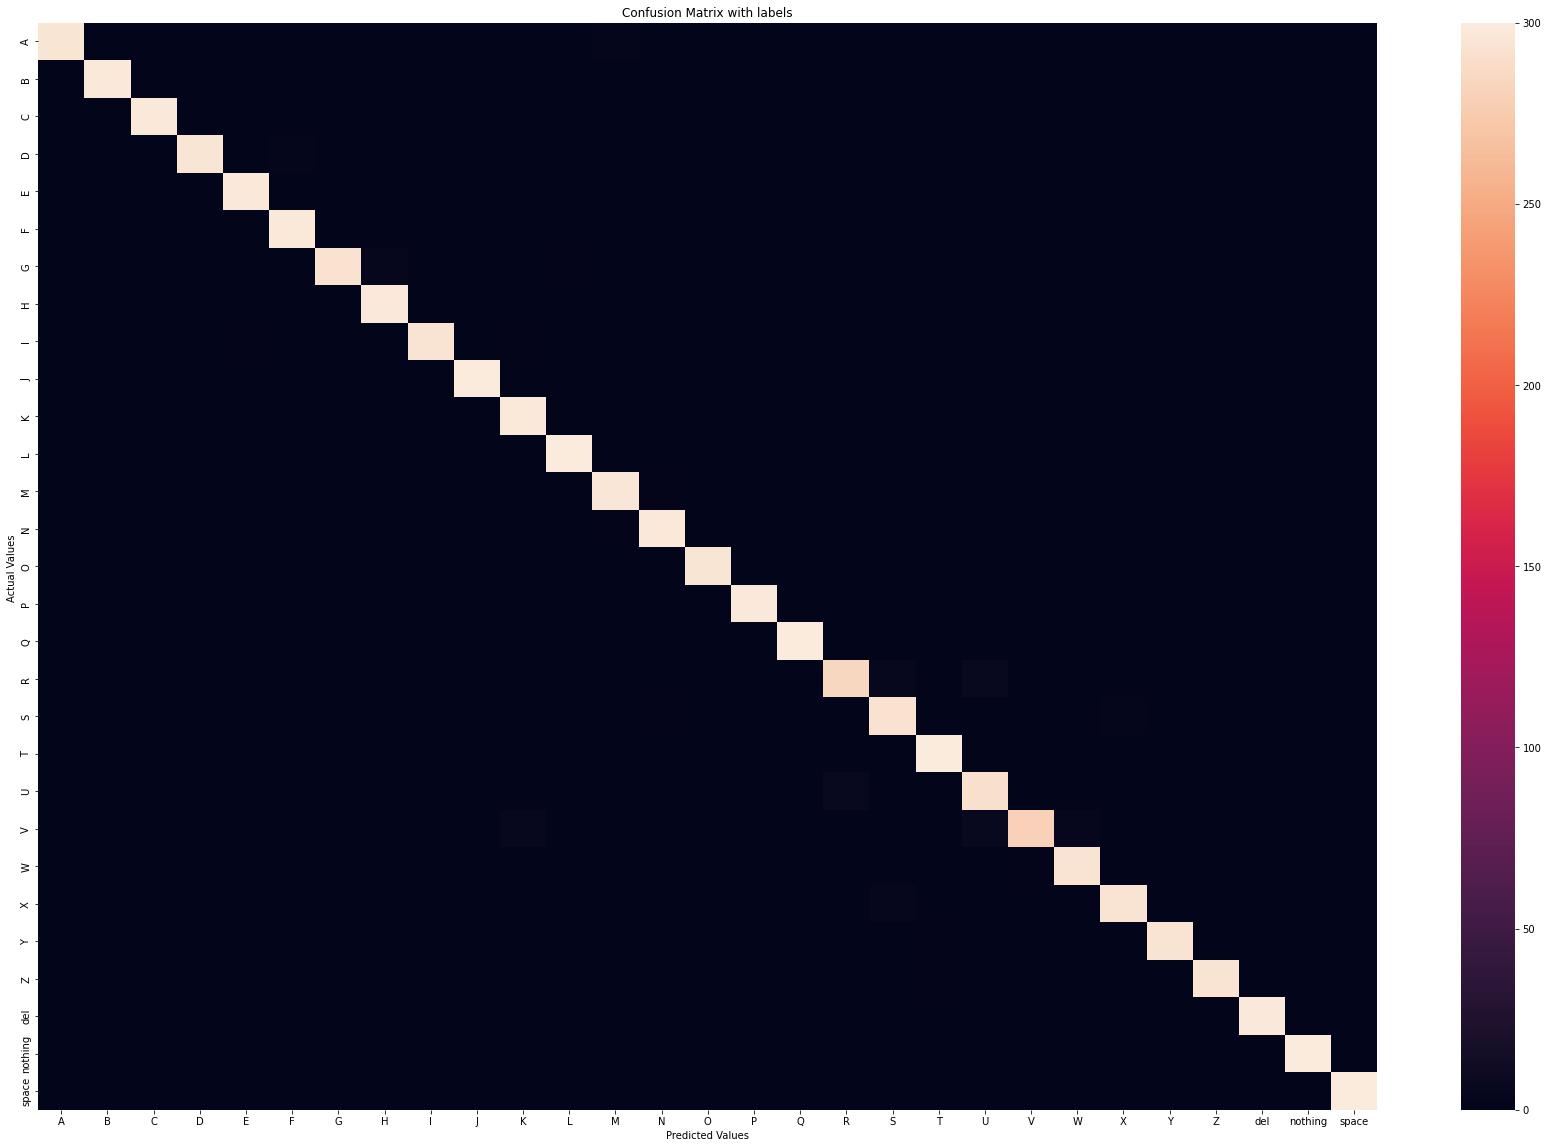

In [13]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [14]:
model.save('signInceptionV3_3.h5')

In [15]:
confusion = metrics.confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[295   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0   0   0
    1   1   0   0   0   0   0   0   0   0   0]
 [  1 297   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1   0   0   0   0   0   0]
 [  0   1 297   0   0   0   0   0   0   0   0   0   0   1   0   0   1   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 295   0   3   0   0   0   0   0   0   0   0   1   0   0   0
    0   0   0   0   0   1   0   0   0   0   0]
 [  1   0   0   0 297   0   0   0   0   0   0   0   1   0   0   0   0   0
    1   0   0   0   0   0   0   0   0   0   0]
 [  0   1   1   0   0 297   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0 292   4   0   0   0   2   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0 298   0   1   0   0   0   0   0   1   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 

<AxesSubplot:>

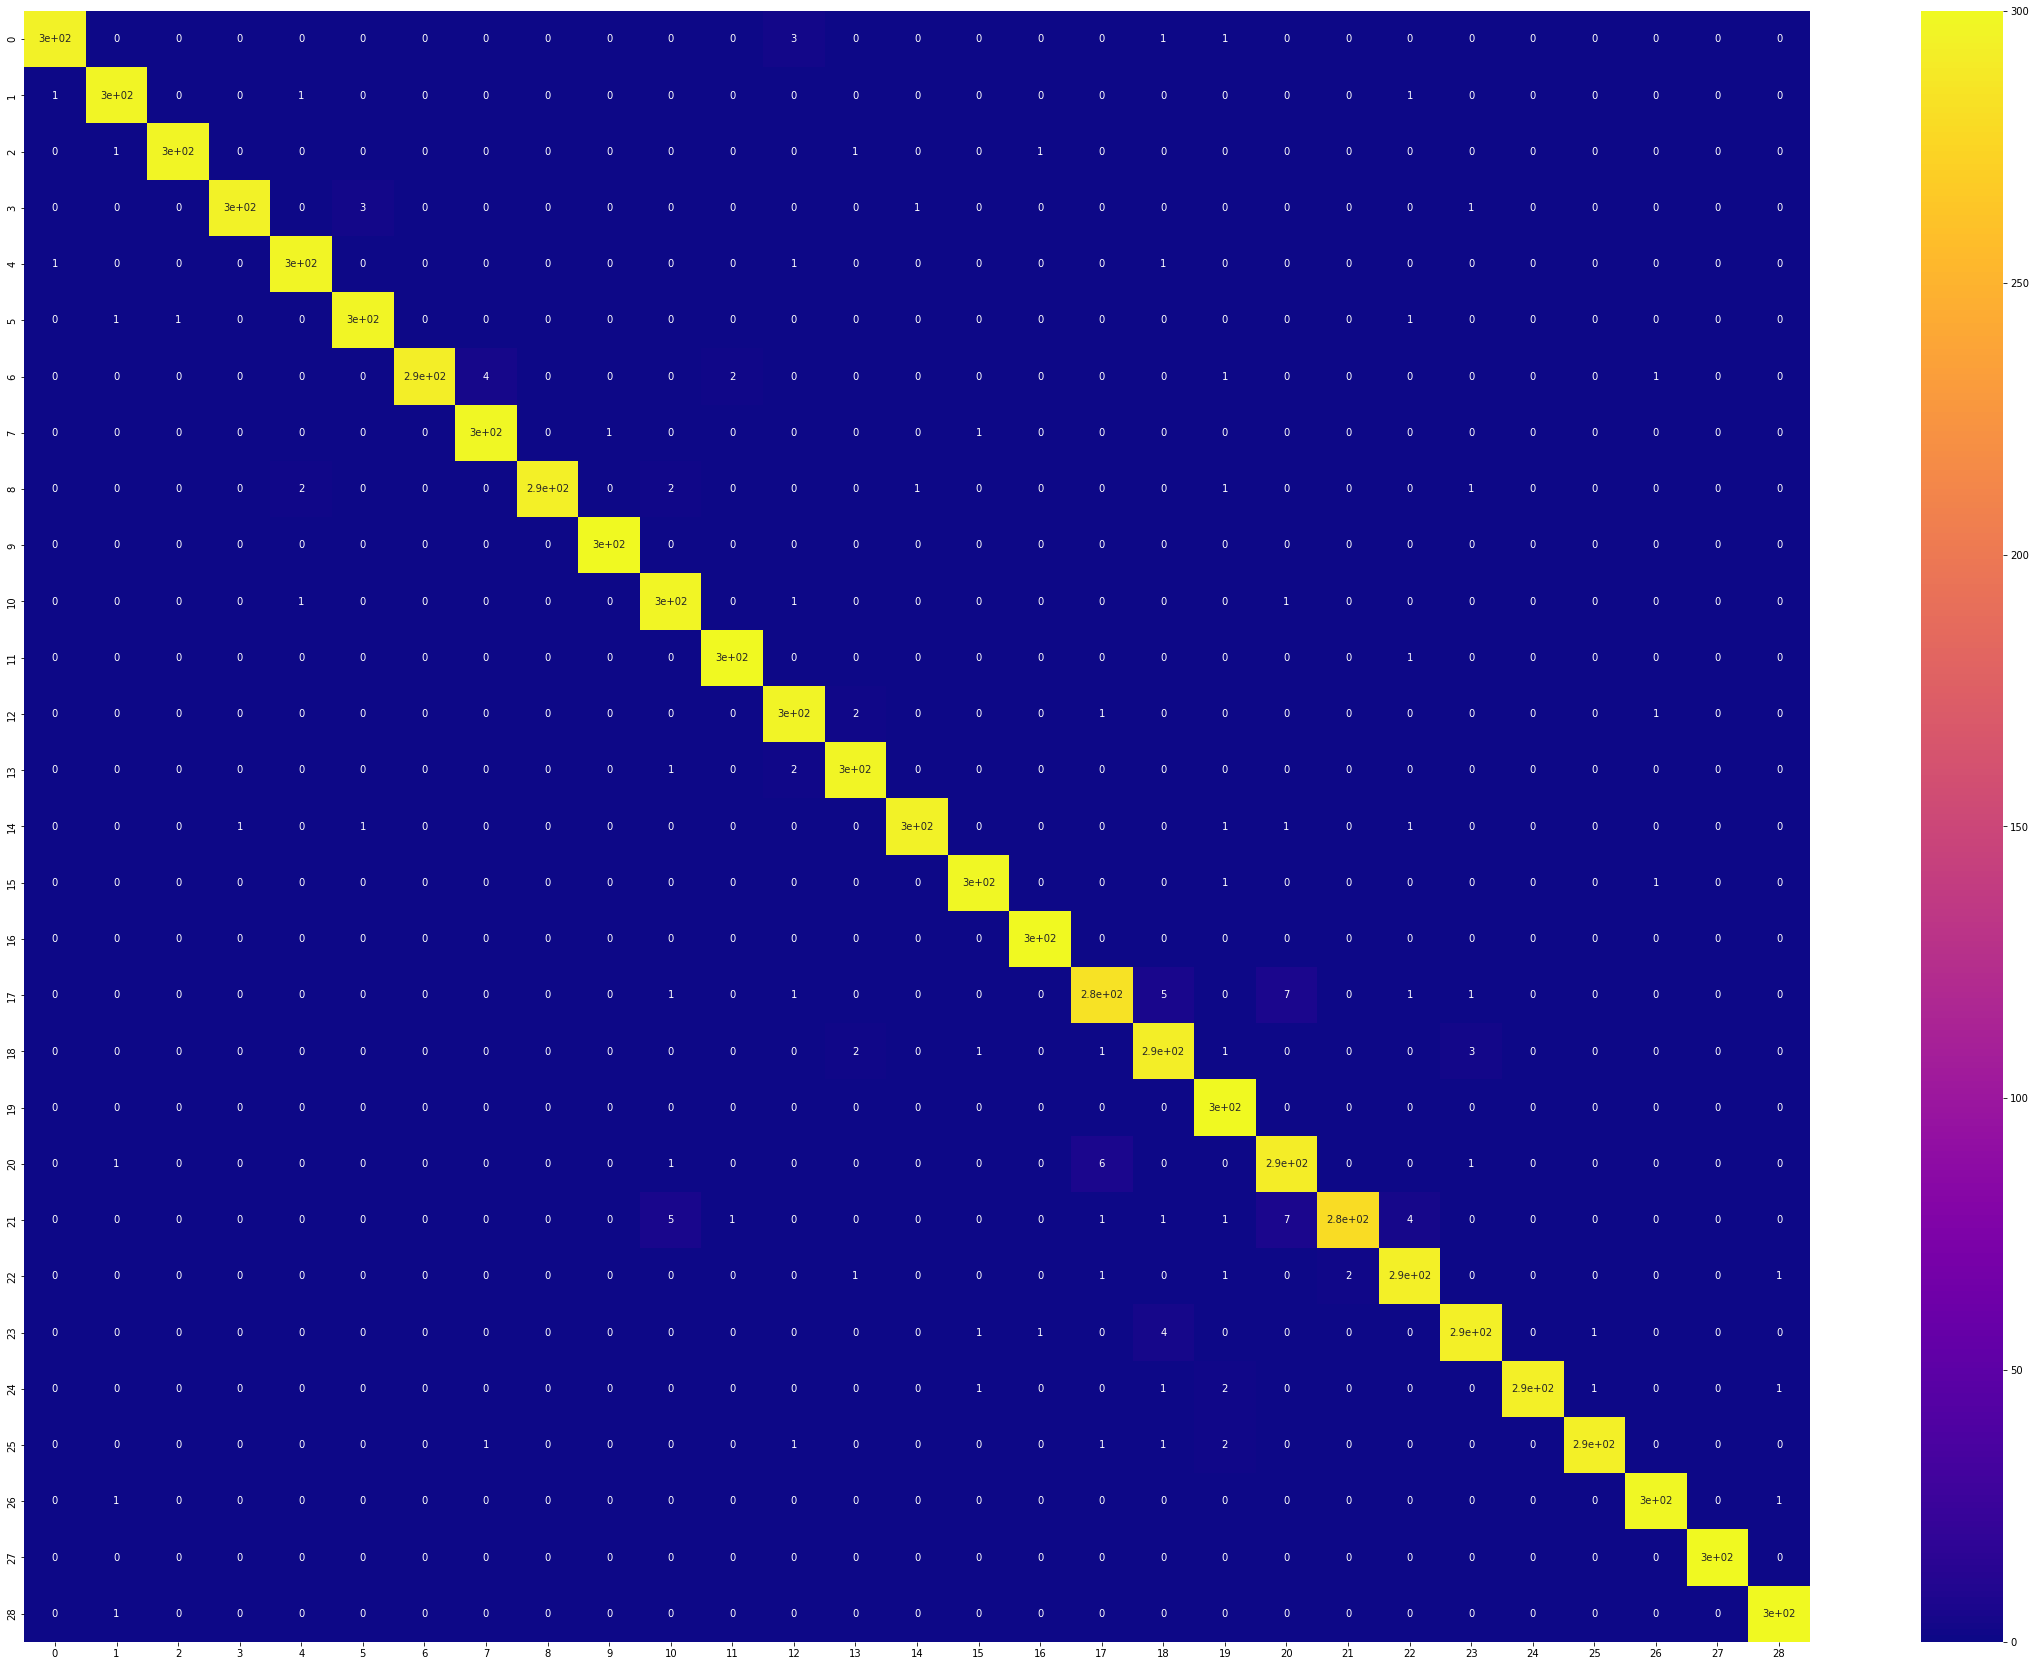

In [16]:
plt.figure(figsize=(40, 30))
sns.heatmap(confusion, cmap="plasma", annot=True)

In [18]:
model.download("signInceptionV3_3.h5")

AttributeError: 'Sequential' object has no attribute 'download'

In [21]:
# serialize model structure to JSON
model_json = model.to_json()
with open("inceptionV3_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# from keras.models import model_from_json
# import numpy as np

# class ASLGestures(object):

#     Gestures_List = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

#     def __init__(self, model_json_file, model_weights_file):
#         # load model from JSON file
#         with open(model_json_file, "r") as json_file:
#             loaded_model_json = json_file.read()
#             self.loaded_model = model_from_json(loaded_model_json)

#         # load weights into the new model
#         self.loaded_model.load_weights(model_weights_file)
#         self.loaded_model._make_predict_function()

#     def predict_gesture(self, img):
#         self.preds = self.loaded_model.predict(img)
#         return ASLGestures.Gestures_List[np.argmax(self.preds)]
    
    
    
    
    
# import cv2
# # from ASLGestures import FacialExpressionModel
# import numpy as np

# hand = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# # hand = cv2.CascadeClassifier(‘haar_hand.xml’)
# model = ASLGestures("model.json", "signInceptionV3_3.h5")
# font = cv2.FONT_HERSHEY_SIMPLEX

# class VideoCamera(object):
#     def __init__(self):
#         self.video = cv2.VideoCapture(0)

#     def __del__(self):
#         self.video.release()

#     # returns camera frames along with bounding boxes and predictions
#     def get_frame(self):
#         _, fr = self.video.read()
#         gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
#         faces = facec.detectMultiScale(gray_fr, 1.3, 5)

#         for (x, y, w, h) in faces:
#             fc = gray_fr[y:y+h, x:x+w]

#             roi = cv2.resize(fc, (48, 48))
#             pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])

#             cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
#             cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

#         _, jpeg = cv2.imencode('.jpg', fr)
#         return jpeg.tobytes()

In [ ]:
# import cv2
# from ASLGestures import FacialExpressionModel
# import numpy as np

# hand = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# # hand = cv2.CascadeClassifier(‘haar_hand.xml’)
# model = FacialExpressionModel("model.json", "model_weights.h5")
# font = cv2.FONT_HERSHEY_SIMPLEX

# class VideoCamera(object):
#     def __init__(self):
#         self.video = cv2.VideoCapture(0)

#     def __del__(self):
#         self.video.release()

#     # returns camera frames along with bounding boxes and predictions
#     def get_frame(self):
#         _, fr = self.video.read()
#         gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
#         faces = facec.detectMultiScale(gray_fr, 1.3, 5)

#         for (x, y, w, h) in faces:
#             fc = gray_fr[y:y+h, x:x+w]

#             roi = cv2.resize(fc, (48, 48))
#             pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])

#             cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
#             cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

#         _, jpeg = cv2.imencode('.jpg', fr)
#         return jpeg.tobytes()